In [ ]:
import torch
from diffusers import FluxControlPipeline, FluxTransformer2DModel
from diffusers.utils import load_image
from image_gen_aux import DepthPreprocessor
from diffusers import FluxTransformer2DModel, TorchAoConfig
from transformers import DepthAnythingForDepthEstimation, AutoImageProcessor, T5EncoderModel
import accelerate
from transformers import pipeline
from PIL import Image
from torchvision.transforms.functional import pil_to_tensor
from pathlib import Path

torch.backends.cudnn.benchmark = True
torch.set_float32_matmul_precision("medium")

from torchvision.transforms import v2

transforms = v2.Compose([
    v2.ToImage(),
    v2.Grayscale(3)
])

dtype = torch.bfloat16

quant_type = "int8_weight_only"
quantization_config = TorchAoConfig(quant_type)

depth_pipe = pipeline(task="depth-estimation", model="depth-anything/Depth-Anything-V2-Small-hf", model_kwargs={
    "quantization_config": quantization_config
}, use_fast=True)


model_id = "black-forest-labs/FLUX.1-Depth-dev"

save_dir = Path("/tmp")/model_id/quant_type


def preprocess_depth_control_image(control_image):
    est = depth_pipe(control_image)
    # convert("RGB")#
    predicted_depth = est["depth"]
    # pdt = pil_to_tensor(predicted_depth)
    # print("max", pdt.aminmax())
    return predicted_depth.convert("RGB")

def load_from_hf(model_id) -> FluxControlPipeline:
    transformer = FluxTransformer2DModel.from_pretrained(
        model_id,
        subfolder="transformer",
        quantization_config=quantization_config,
        torch_dtype=dtype,
    )

    text_encoder_2 = T5EncoderModel.from_pretrained(
        model_id,
        subfolder="text_encoder_2",
        quantization_config=quantization_config,
        torch_dtype=dtype,
    )

    transformer = torch.compile(transformer, mode="max-autotune", fullgraph=True)

    pipe = FluxControlPipeline.from_pretrained(
        model_id,
        transformer=transformer,
        text_encoder_2=text_encoder_2,
        torch_dtype=dtype,
    )
    return pipe

pipe = load_from_hf(model_id)
# pipe.save_pretrained(save_dir, safe_serialization=False)
# pipe = FluxControlPipeline.from_pretrained(save_dir, torch_dtype=dtype, use_safetensors=False)
pipe = pipe.to("cuda")
# pipe.enable_sequential_cpu_offload()
pipe.enable_model_cpu_offload()


/root/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
`low_cpu_mem_usage` was None, now default to True since model is quantized.
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0
Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 44150.57it/s]
`low_cpu_mem_usage` was None, now default to True since model is quantized.
Loading checkpoint shards: 100%|██████████| 4/4 [00:08<00:00,  2.14s/it]
Expected types for transformer: ['FluxTransformer2DModel'], got OptimizedModule.
Loading pipeline components...:

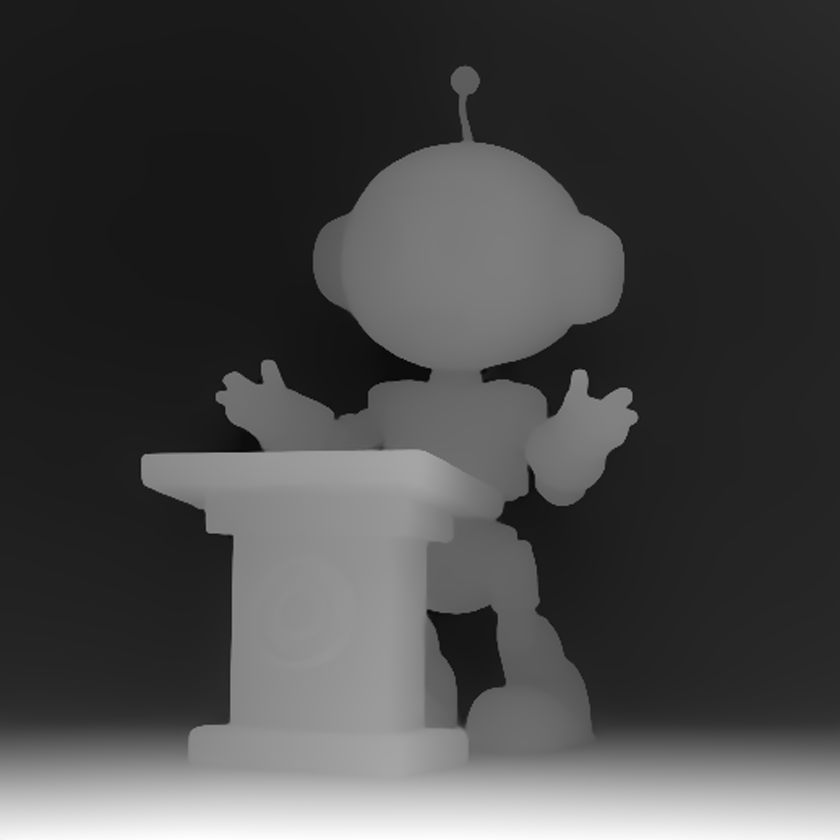

In [2]:
control_image = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/robot.png")

control_image = preprocess_depth_control_image(control_image)
control_image

In [3]:
prompt = "human"


image = pipe(
    prompt=prompt,
    control_image=control_image,
    height=1024,
    width=1024,
    num_inference_steps=30,
    guidance_scale=10.0,
    generator=torch.Generator().manual_seed(42),
).images[0]
image

  0%|          | 0/30 [01:08<?, ?it/s]


KeyboardInterrupt: 